In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\Nikola\AppData\Local\Temp\ipykernel_29496\82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# UCITAVANJE PODATAKA O OBJAVAMA

In [2]:

import pandas as pd

  
# merging the files

path = 'data/reddit2008/submissions_2008_asm/'

df_sub = pd.concat(
    map(pd.read_csv, [path + 'csv-0.csv',path + 'csv-1.csv',
                      path + 'csv-2.csv',path + 'csv-3.csv', 
                        path + 'csv-4.csv',path + 'csv-5.csv',
                      path + 'csv-6.csv',path + 'csv-7.csv',
                      path + 'csv-8.csv',path + 'csv-9.csv', 
                        path + 'csv-10.csv',path + 'csv-11.csv',
                     ]), ignore_index=True)
print(df_sub.columns)




C:\Users\Nikola\AppData\Local\Temp\ipykernel_29496\1306589312.py:8: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sub = pd.concat(
C:\Users\Nikola\AppData\Local\Temp\ipykernel_29496\1306589312.py:8: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sub = pd.concat(


Index(['Unnamed: 0', 'id', 'url', 'permalink', 'author', 'created_utc',
       'subreddit', 'subreddit_id', 'num_comments', 'score', 'over_18',
       'distinguished', 'domain', 'stickied', 'locked', 'hide_score'],
      dtype='object')


# UCITAVANJE PODATAKA O KOMENTARIMA

In [3]:
path = 'data/reddit2008/comments_2008_asm/comments_2008/'

df_comm = pd.concat(
    map(pd.read_csv, [path + 'csv-0.csv',path + 'csv-1.csv',
                      path + 'csv-2.csv',path + 'csv-3.csv', 
                        path + 'csv-4.csv',path + 'csv-5.csv',
                      path + 'csv-6.csv',path + 'csv-7.csv',
                      path + 'csv-8.csv',path + 'csv-9.csv', 
                        path + 'csv-10.csv',path + 'csv-11.csv',
                     ]), ignore_index=True)
print(df_comm.columns)
print(df_comm.shape)

C:\Users\Nikola\AppData\Local\Temp\ipykernel_29496\89109711.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comm = pd.concat(
C:\Users\Nikola\AppData\Local\Temp\ipykernel_29496\89109711.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comm = pd.concat(


Index(['Unnamed: 0', 'id', 'author', 'link_id', 'parent_id', 'created_utc',
       'subreddit', 'subreddit_id', 'score', 'distinguished', 'gilded',
       'controversiality'],
      dtype='object')
(7242871, 12)


## CISCENJE OBJAVA

In [4]:
res_unique = df_sub['id'].is_unique
res_null = df_sub['id'].isnull().values.any()
print(df_sub.shape)
df_sub = df_sub.loc[df_sub['author']!='[deleted]']
print(res_unique)
print(res_null)
print(df_sub.shape)

(2519853, 16)
True
False
(2044810, 16)


In [5]:
import pickle

df_sub= df_sub[['id' , 'url' , 'permalink', 'author' , 'created_utc', 'subreddit', 'subreddit_id', 'num_comments', 'over_18']]
print(df_sub.shape)
with open("data/cleaned/sub" , "wb") as f:
    pickle.dump(df_sub , f)
    


(2044810, 9)


## CISCENJE KOMENTARA

In [6]:
res_unique = df_comm['id'].is_unique
res_null = df_comm['id'].isnull().values.any()

print(res_unique)
print(res_null)

True
True


In [7]:
df_comm_null = df_comm[df_comm['id'].isnull()]
df_comm_null.head(5)
df_comm.iloc[6422487, 1] = 'x'
res_null = df_comm['id'].isnull().values.any()
print(res_null)
print("Pre ciscenja ", df_comm.shape)

df_comm.replace({'parent_id': r'^.*_(.*)$'}, {'parent_id': r'\1'}, regex=True, inplace=True)
df_comm = df_comm.loc[df_comm['author']!='[deleted]'] #izbacujemo iz dataset-a komentare korisnika koji su obrisali nalog
print("posle ciscenja ", df_comm.shape)

False
Pre ciscenja  (7242871, 12)
posle ciscenja  (4873690, 12)


In [8]:
df_comm= df_comm[['id' , 'author' , 'link_id' , 'parent_id', 'subreddit', 'subreddit_id']]
with open("data/cleaned/comm" , "wb") as f:
    pickle.dump(df_comm , f)

# KREIRANJE SNET MREZE


In [116]:
import networkx as nx
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

with open("data/cleaned/sub", 'rb') as f:
    sub = pickle.load(f)
with open("data/cleaned/comm", 'rb') as f:
    comm = pickle.load(f)

print(sub.shape)
print(comm.shape)

(2044810, 9)
(4873690, 6)


In [117]:
list_sub = set(sub['subreddit'].unique())
list_comm = set(comm['subreddit'].unique())

set_of_subreddits = list_sub.union(list_comm)
print("Broj nodova je: ", len(set_of_subreddits))
G = nx.Graph() # pravi praznu mrežu
G.add_nodes_from(set_of_subreddits) # dodaje čvorove čije su labele u "set_of_subreddits"

Broj nodova je:  4359


In [118]:
data = pd.concat([comm[['author', 'subreddit']], sub[['author', 'subreddit']]], ignore_index=True)
dataG = data.groupby(['author']).agg(subreddits=('subreddit', 'unique'))

cntThen = 0
cntElse = 0
maxLength = 0
for _, list_data in dataG.itertuples():
    i = 0
    length = len(list_data)
    while (i <  length - 1):
        j = i+1
        while(j < length):
            if (list_data[i], list_data[j]) in G.edges:
                G.edges[list_data[i], list_data[j]]['weight'] += 1
                cntThen +=1
            else:
                G.add_edge(list_data[i], list_data[j], weight=1) 
                cntElse +=1
            j +=1
        i+=1

In [119]:
print("Then: " , cntThen)
print("Else: " , cntElse)
print(maxLength)
print(nx.info(G))

Then:  3526721
Else:  156959
0
Graph with 4359 nodes and 156959 edges


C:\Users\Nikola\AppData\Local\Temp\ipykernel_29496\3139123140.py:4: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [120]:
G.edges.data("weight")

EdgeDataView([('newscrux', 'entertainment', 1), ('newscrux', 'reddit.com', 1), ('Cubicleddit', 'science', 1), ('Cubicleddit', 'technology', 1), ('Cubicleddit', 'business', 1), ('Cubicleddit', 'WTF', 1), ('Cubicleddit', 'worldnews', 1), ('Cubicleddit', 'reddit.com', 1), ('Cubicleddit', 'politics', 1), ('Cubicleddit', 'programming', 1), ('Cubicleddit', 'pics', 1), ('Cubicleddit', 'geek', 1), ('ekerala', 'reddit.com', 1), ('ekerala', 'WTF', 1), ('ekerala', 'worldnews', 1), ('reference', 'reddit.com', 1), ('SexyLinks', 'reddit.com', 1), ('SexyLinks', 'PersianToronto', 1), ('chicago', 'reddit.com', 35), ('chicago', 'crime', 1), ('chicago', 'AskReddit', 21), ('chicago', 'obama', 12), ('chicago', 'Economics', 14), ('chicago', 'funny', 30), ('chicago', 'videos', 11), ('chicago', 'technology', 28), ('chicago', 'WTF', 26), ('chicago', 'wikipedia', 10), ('chicago', 'environment', 12), ('chicago', 'politics', 32), ('chicago', 'programming', 20), ('chicago', 'pics', 31), ('chicago', 'sports', 6), (

In [108]:
nx.write_gml(G, "graphs/snet.gml")

# Odgovori Na Pitanja

### 7 - Gustina Mreze je 0.025 (iz Gephi alata)

### 8 - Prosecne distance iznose:  2.099. Dijametar mreze je: 5 (iz Gephi alata)

### 9 - Povezane komponente

In [121]:
print("Broj povezanih kompnenti: " , nx.number_connected_components(G))

Broj povezanih kompnenti:  814


In [122]:
connected_componnets = sorted(nx.connected_components(G), key=len, reverse=True)
print("Velicina povezanih komponenti:")
for x in connected_componnets:
    print(len(x) , "  ")

Velicina povezanih komponenti:
3524   
3   
3   
3   
2   
2   
2   
2   
2   
2   
2   
2   
2   
2   
2   
2   
2   
2   
2   
2   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1   
1

In [90]:
giant = G.subgraph(connected_componnets[0]).copy()
nx.info(giant)

C:\Users\Nikola\AppData\Local\Temp\ipykernel_29496\3524112525.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(giant)


'Graph with 3524 nodes and 156934 edges'

Posotji gigantska komponenta

### 10 - Globalni i prosecni koeficijent klasterizacije

In [123]:
print( "Prosecni koeficijent klasterizacije: " , nx.average_clustering(giant), ", Globalni koeficijent klasterizacije: " , nx.transitivity(giant) )

Prosecni koeficijent klasterizacije:  0.7705443947900464 , Globalni koeficijent klasterizacije:  0.26730816965364673


In [19]:
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
def plot_deg_frequency(G):
    
    _, deg_list = zip(*nx.clustering(G).items())
    l = []
    for k in deg_list:
        if k > 0:
            l.append(k)
    
    deg_counts = Counter(l)        
    print(deg_counts)
    x, y = zip(*deg_counts.items())                                                      

    plt.figure(1)   


    plt.xlabel('weighted degree')                                                                                                        
    plt.xscale('linear')                                                                                                                
    plt.xlim(0, max(x))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale('linear')                                                                                                                
    plt.ylim(1, max(y))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(x, y, marker='.')                                                                                                    
    plt.show()

Counter({1.0: 1665, 0.8333333333333334: 8, 0.8: 6, 0.9333333333333333: 5, 0.7142857142857143: 4, 0.8571428571428571: 4, 0.5: 4, 0.9975369458128078: 4, 0.9969230769230769: 3, 0.8214285714285714: 3, 0.6666666666666666: 3, 0.3333333333333333: 3, 0.8181818181818182: 3, 0.9047619047619048: 3, 0.9571428571428572: 2, 0.9961538461538462: 2, 0.9608636977058029: 2, 0.9926829268292683: 2, 0.9970161977834612: 2, 0.9885057471264368: 2, 0.9941520467836257: 2, 0.972972972972973: 2, 0.9895470383275261: 2, 0.9545454545454546: 2, 0.9446640316205533: 2, 0.9285714285714286: 2, 0.9777777777777777: 2, 0.9904761904761905: 2, 0.9619047619047619: 2, 0.9838383838383838: 2, 0.9951219512195122: 2, 0.9978494623655914: 2, 0.8809523809523809: 2, 0.6727272727272727: 2, 0.9715909090909091: 2, 0.8928571428571429: 2, 0.9526315789473684: 2, 0.9736842105263158: 2, 0.7833333333333333: 2, 0.9166666666666666: 2, 0.5714285714285714: 2, 0.987012987012987: 2, 0.9653092006033183: 2, 0.9705882352941176: 2, 0.9661222020568663: 2, 

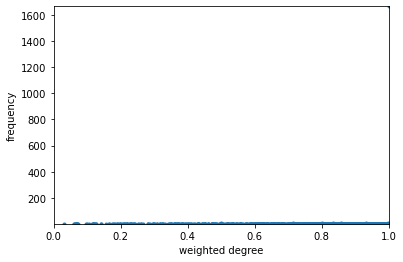

In [20]:
plot_deg_frequency(giant)

0.025281247311730953
Counter({0.025: 20, 0.023809523809523808: 15, 0.02857142857142857: 14, 0.023255813953488372: 13, 0.024096385542168676: 12, 0.025322503583373148: 12, 0.025974025974025976: 12, 0.023803009575923392: 12, 0.025293586269196026: 12, 0.02490842490842491: 11, 0.02531645569620253: 11, 0.02442002442002442: 10, 0.024817136886102403: 10, 0.02197802197802198: 10, 0.022222222222222223: 10, 0.02638453500522466: 9, 0.025791624106230846: 9, 0.027034969144872172: 9, 0.024777933613838243: 9, 0.023529411764705882: 9, 0.025712949976624593: 9, 0.027777777777777776: 9, 0.025718194254445964: 9, 0.026391279403327597: 9, 0.0273492286115007: 8, 0.026862026862026864: 8, 0.0226890756302521: 8, 0.02610441767068273: 8, 0.026755852842809364: 8, 0.02586206896551724: 8, 0.024897400820793433: 8, 0.02512697139802192: 8, 0.024369747899159664: 8, 0.022988505747126436: 8, 0.024691358024691357: 8, 0.025339602925809824: 8, 0.02585220773278426: 8, 0.02546816479400749: 8, 0.024074074074074074: 8, 0.02587719

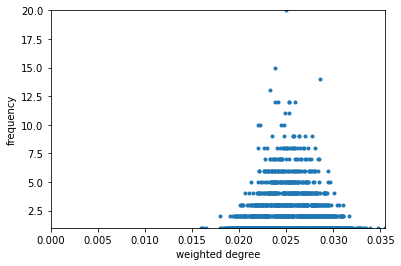

In [21]:
n = giant.number_of_nodes()
m = giant.number_of_edges()

p = ( 2*float(m) ) / ( n* (n-1) )
print(p)
G_er = nx.erdos_renyi_graph(n, p)
plot_deg_frequency(G_er)

Klasterizacija je jako izrazena sto se moze videti i sa grafika



### 11 - Da. Mreza iskazuje osobine malog sveta. To se moze zakljuciti na osnovu visoke klasterizacije i prosecne duzine puta

In [22]:
giant.edges()

EdgeView([('newscrux', 'entertainment'), ('newscrux', 'reddit.com'), ('Cubicleddit', 'science'), ('Cubicleddit', 'technology'), ('Cubicleddit', 'business'), ('Cubicleddit', 'WTF'), ('Cubicleddit', 'worldnews'), ('Cubicleddit', 'reddit.com'), ('Cubicleddit', 'politics'), ('Cubicleddit', 'programming'), ('Cubicleddit', 'pics'), ('Cubicleddit', 'geek'), ('ekerala', 'reddit.com'), ('ekerala', 'WTF'), ('ekerala', 'worldnews'), ('reference', 'reddit.com'), ('SexyLinks', 'reddit.com'), ('SexyLinks', 'PersianToronto'), ('chicago', 'reddit.com'), ('chicago', 'crime'), ('chicago', 'AskReddit'), ('chicago', 'obama'), ('chicago', 'Economics'), ('chicago', 'funny'), ('chicago', 'videos'), ('chicago', 'technology'), ('chicago', 'WTF'), ('chicago', 'wikipedia'), ('chicago', 'environment'), ('chicago', 'politics'), ('chicago', 'programming'), ('chicago', 'pics'), ('chicago', 'sports'), ('chicago', 'food'), ('chicago', 'geek'), ('chicago', 'entertainment'), ('chicago', 'news'), ('chicago', 'science'), 

### 12 -  asortativna analiza


Koeficijent asortativnosti na osnovu netežinskog stepena čvora: -0.43670253754011024


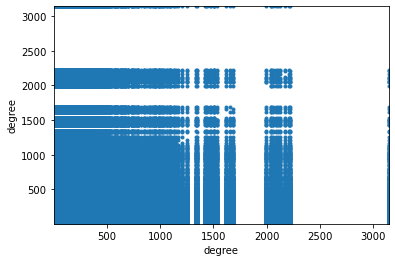

In [24]:
r1 = nx.degree_assortativity_coefficient(giant)
print(f"Koeficijent asortativnosti na osnovu netežinskog stepena čvora: {r1}")

def plot_deg_corr(g, xscale = "linear", yscale = "linear"):
    first = []
    second = []
    for i, k in g.edges():
        first.append(g.degree(i))
        first.append(g.degree(k))
        second.append(g.degree(k))
        second.append(g.degree(i))

    plt.figure(1)   

    plt.xlabel('degree')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(first)) 

    plt.ylabel('degree')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(second))                                                                                                             

    plt.scatter(first, second, marker='.')                                                                                                    
    plt.show()

plot_deg_corr(giant)

### 13 - Klub bogatih


In [113]:
d = []
for _, x in giant.degree():
    d.append(x)

GH = nx.havel_hakimi_graph(d)
print("Asortativnost SNET: ", r1 , "---Asortativnost Hakimi: ", nx.degree_assortativity_coefficient(GH))

Asortativnost SNET:  -0.43670253754011024 ---Asortativnost Hakimi:  -0.4146303462806617


Posto su asortativnosti slicne, zakljucujemo da mreza ispoljava fenomen kluba bogatih

### 14 - Power Law


In [26]:
from collections import Counter
from operator import itemgetter

def plot_deg_frequency(G, weighted = False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
        
    _, deg_list = zip(*degrees)
    deg_counts = Counter(deg_list)        
    print(deg_counts)
    x, y = zip(*deg_counts.items())                                                      

    plt.figure(1)   

    # prep axes   
    if weighted:
        plt.xlabel('weighted degree')  
    else:
        plt.xlabel('degree')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(x))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(y))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(x, y, marker='.')                                                                                                    
    plt.show()

Counter({1: 530, 2: 250, 3: 148, 5: 97, 4: 86, 6: 77, 11: 50, 10: 44, 8: 43, 7: 43, 18: 41, 14: 39, 16: 39, 13: 38, 12: 38, 9: 36, 24: 35, 20: 31, 29: 31, 17: 30, 25: 30, 19: 29, 21: 29, 23: 28, 22: 28, 28: 27, 26: 27, 15: 25, 43: 25, 31: 23, 30: 23, 38: 22, 33: 22, 78: 21, 32: 20, 49: 20, 36: 19, 45: 19, 39: 19, 44: 18, 50: 17, 48: 17, 27: 17, 37: 17, 56: 16, 64: 16, 41: 16, 42: 16, 121: 15, 40: 15, 35: 15, 57: 14, 83: 14, 34: 14, 180: 14, 55: 14, 84: 13, 74: 13, 75: 13, 46: 13, 68: 12, 52: 12, 54: 12, 51: 11, 95: 11, 67: 11, 61: 11, 60: 11, 62: 11, 90: 10, 58: 10, 96: 10, 59: 10, 71: 10, 72: 9, 99: 9, 101: 9, 66: 9, 47: 9, 92: 8, 103: 8, 73: 8, 115: 8, 86: 8, 93: 8, 122: 8, 69: 8, 80: 8, 81: 8, 89: 8, 85: 7, 65: 7, 70: 7, 102: 7, 135: 7, 63: 7, 76: 7, 192: 7, 157: 7, 125: 7, 91: 7, 114: 7, 106: 7, 228: 6, 138: 6, 109: 6, 120: 6, 140: 6, 88: 5, 98: 5, 132: 5, 105: 5, 107: 5, 87: 5, 162: 5, 127: 5, 53: 5, 153: 5, 193: 5, 100: 5, 181: 5, 149: 5, 183: 5, 256: 5, 104: 5, 200: 4, 128: 4, 1

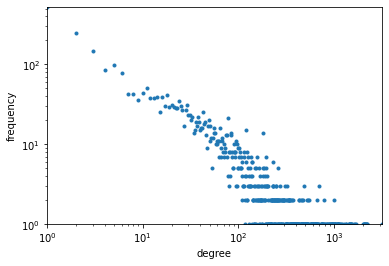

In [27]:
plot_deg_frequency(giant)

In [124]:
import powerlaw
degree_sequence = sorted([d for n, d in giant.degree()], reverse=True)
results = powerlaw.Fit(degree_sequence)
print(results)
results.supported_distributions

Calculating best minimal value for power law fit


{'power_law': powerlaw.Power_Law,
 'lognormal': powerlaw.Lognormal,
 'exponential': powerlaw.Exponential,
 'truncated_power_law': powerlaw.Truncated_Power_Law,
 'stretched_exponential': powerlaw.Stretched_Exponential,
 'lognormal_positive': powerlaw.Lognormal_Positive}

In [132]:

R, p = results.distribution_compare('power_law', 'truncated_power_law')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")
R, p = results.distribution_compare('power_law', 'exponential')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")
R, p = results.distribution_compare('truncated_power_law', 'power_law')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")
R, p = results.distribution_compare('stretched_exponential', 'truncated_power_law')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")

Loglikelihood ratio: -15.613893371177623
Statistical significance: 2.2945806810170666e-08
Loglikelihood ratio: 22.582676543743453
Statistical significance: 0.0730904396689174
Loglikelihood ratio: 15.613893371177623
Statistical significance: 2.2945806810170666e-08
Loglikelihood ratio: -1.6226464808631436
Statistical significance: 0.00964979892212571


Assuming nested distributions
Assuming nested distributions


Pošto je p-value za prvi i treci slučaj značajno manje od 0.05 zakljucujemo da  truncated_power_law  mnogo bolje fituje od eksponencijalne ili power law raspodele

### 15 -  Habovi i autoriteti

Posto je graf neusmeren, nakon pokretanja analize u alatu Gephi, klikom na dugmee "HITS", vidimo da su rezultati za habove i autoritete isti. 

### 16 - centralnosti

In [30]:
def calculate_centralities(G):

    DC_dict = nx.degree_centrality(G)
    CC_dict = nx.closeness_centrality(G)
    BC_dict = nx.betweenness_centrality(G)
    EVC_dict = nx.eigenvector_centrality(G, weight='weight')

    df1 = pd.DataFrame.from_dict(DC_dict, orient='index', columns=['DC'])
    df2 = pd.DataFrame.from_dict(CC_dict, orient='index', columns=['CC'])
    df3 = pd.DataFrame.from_dict(BC_dict, orient='index', columns=['BC'])
    df4 = pd.DataFrame.from_dict(EVC_dict, orient='index', columns=['EVC'])
    df = pd.concat([df1, df2, df3, df4], axis=1)
    return df

In [31]:
data_cent = calculate_centralities(giant)

### Po Bliskosti

In [32]:
df_cc = pd.DataFrame({'CC':data_cent['CC']})

df_cc.nlargest(5, 'CC')

CC
reddit.com  0.901946
technology  0.728344
politics    0.726092
pics        0.720155
funny       0.712581

### Po Stepenu

In [33]:
df_dc = pd.DataFrame({'DC':data_cent['DC']})
df_dc.nlargest(5, 'DC')

DC
reddit.com  0.892137
technology  0.630429
politics    0.627590
pics        0.616236
funny       0.602611

### Relaciona

In [34]:
df_dc = pd.DataFrame({'BC':data_cent['BC']})
df_dc.nlargest(5, 'BC')

BC
reddit.com   0.368655
technology   0.049371
programming  0.043635
politics     0.043049
business     0.041292

### 17 - Po Sopstvenom vekotru

In [35]:
df_dc = pd.DataFrame({'EVC':data_cent['EVC']})
df_dc.nlargest(5, 'EVC')

EVC
reddit.com  0.374684
politics    0.312669
pics        0.291857
funny       0.279569
science     0.273050

### 18 - Katz-ova skala

In [36]:
import scipy.stats as stats
lambda_max =  max(nx.adjacency_spectrum(G))
print(1/lambda_max)

C:\Users\Nikola\anaconda3\lib\site-packages\networkx\linalg\spectrum.py:110: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return sp.linalg.eigvals(nx.adjacency_matrix(G, weight=weight).todense())


(5.4519259844056895e-06+0j)


#### Standardno Beta isto za sve

In [101]:
KatzC_dict = nx.katz_centrality(giant, alpha=3e-06, beta=1.0, max_iter=1000, tol=1e-06, nstart=None, normalized=True, weight='weight')
df_katzc = pd.DataFrame.from_dict(KatzC_dict, orient='index', columns=['KC'])
df_katzc.nlargest(10, 'KC')

KC
reddit.com     0.060543
politics       0.052976
pics           0.050790
funny          0.049352
science        0.048693
technology     0.047579
worldnews      0.046893
WTF            0.046878
entertainment  0.045551
programming    0.042405

#### Beta za reddit.com = 1, ostali 0.1

In [107]:
l = {}
for i in giant.nodes():
    l[i] = 0.1
l['reddit.com'] = 1 

KatzC_dict = nx.katz_centrality(giant, alpha=3e-06, beta=l, max_iter=1000, tol=1e-06, nstart=None, normalized=True, weight='weight')
df_katzc = pd.DataFrame.from_dict(KatzC_dict, orient='index', columns=['KC'])
df_katzc.nlargest(10, 'KC')

KC
reddit.com     0.215896
politics       0.074735
pics           0.069669
funny          0.067229
science        0.066018
technology     0.064776
worldnews      0.063265
WTF            0.062889
entertainment  0.061700
business       0.056555

### 19 - kompozitni rank

In [38]:

labele = ['DC', 'CC', 'BC', 'EVC', 'KC']
data_helper = pd.concat([data_cent , df_katzc ] , axis = 1)
df_ = data_helper
for metric in labele:
    df_[f"{metric}_rank"] = df_[f"{metric}"].rank(ascending=False) 
    
df_['composite_rank'] = df_['DC_rank'] * df_['CC_rank'] * df_['BC_rank'] * df_['EVC_rank'] * df_['KC_rank']
df_.nsmallest(10, 'composite_rank')
#df_.sort_values(['CC'], ascending = False, inplace=True)

DC        CC        BC       EVC        KC  DC_rank  \
reddit.com     0.892137  0.901946  0.368655  0.374684  0.060543      1.0   
politics       0.627590  0.726092  0.043049  0.312669  0.052976      3.0   
technology     0.630429  0.728344  0.049371  0.263952  0.047579      2.0   
pics           0.616236  0.720155  0.037606  0.291857  0.050790      4.0   
funny          0.602611  0.712581  0.032315  0.279569  0.049352      5.0   
science        0.597502  0.710139  0.031917  0.273050  0.048693      6.0   
worldnews      0.593528  0.708425  0.033658  0.258876  0.046893      7.0   
programming    0.579903  0.700816  0.043635  0.220668  0.042405     10.0   
entertainment  0.585013  0.704037  0.037757  0.247071  0.045551      8.0   
WTF            0.580187  0.701374  0.028495  0.257432  0.046878      9.0   

               CC_rank  BC_rank  EVC_rank  KC_rank  composite_rank  
reddit.com         1.0      1.0       1.0      1.0             1.0  
politics           3.0      4.0       2.0      2.0           144.0  
technology         2.0      2.0       6.0      6.0           288.0  
pics               4.0      7.0       3.0      3.0          1008.0  
funny              5.0      9.0       4.0      4.0          3600.0  
science            6.0     10.0       5.0      5.0          9000.0  
worldnews          7.0      8.0       7.0      7.0         19208.0  
programming       10.0      3.0      10.0     10.0         30000.0  
entertainment      8.0      6.0       9.0      9.0         31104.0  
WTF                9.0     11.0       8.0      8.0         57024.0

### 20 -  Spektarska analiza

<class 'networkx.utils.decorators.argmap'> compilation 33:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


     k      lambda_k
0    1 -1.353707e-11
1    2  2.681532e-01
2    3  5.110828e-01
3    4  5.758798e-01
4    5  7.384283e-01
5    6  7.639315e-01
6    7  7.643149e-01
7    8  8.297834e-01
8    9  8.362588e-01
9   10  8.379027e-01
10  11  8.416228e-01
11  12  9.072753e-01
12  13  9.099429e-01
13  14  9.293559e-01
14  15  9.371039e-01
15  16  9.415129e-01
16  17  9.616547e-01
17  18  9.654971e-01
18  19  9.706613e-01
19  20  9.738569e-01
20  21  9.824536e-01
21  22  9.835595e-01
22  23  9.848467e-01
23  24  9.886509e-01
24  25  9.933860e-01
25  26  9.937786e-01
26  27  9.939394e-01
27  28  9.953147e-01
28  29  9.958993e-01
29  30  9.960289e-01


C:\Users\Nikola\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\Nikola\anaconda3\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


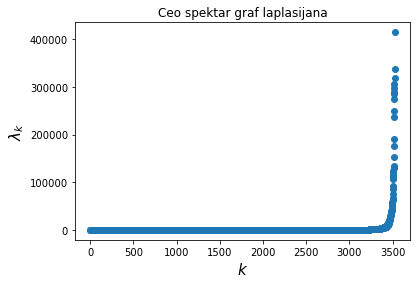

In [39]:
from scipy import linalg
def plot_scatterplot(x_data, y_data, x_label, y_label, title):
    fig, ax = plt.subplots()
    ax.scatter(x_data, y_data) 
    ax.set_ylabel(y_label, fontsize=15)
    ax.set_xlabel(x_label, fontsize=15)
    ax.set_title(title)
    plt.show() 
    
L = nx.laplacian_matrix(giant).toarray()

eigenvalues = linalg.eigvals(L) # TODO: change to .eigenvalsh because we know the matrix is symmetric
eigenvalues.sort()
enumerator = np.array(range(1, len(eigenvalues)+1))
df_eig = pd.DataFrame(list(zip(enumerator, eigenvalues)))

# write eigenvalue table
df_eig30 = df_eig[:30]
df_eig30.columns = ['k', 'lambda_k']
df_eig30 = df_eig30.astype({'k': 'int32', 'lambda_k':'float'})
print(df_eig30)
plot_scatterplot(enumerator, eigenvalues, r'$k$', r'$\lambda_k$', 'Ceo spektar graf laplasijana')

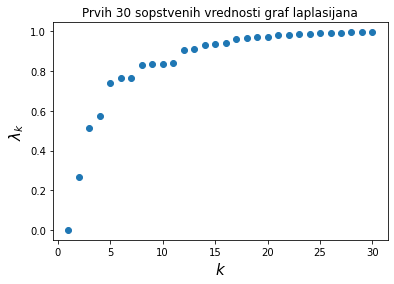

In [40]:
# prvih 30 sopstvenih vrednosti

df_eig_30 = df_eig[:30]

plot_scatterplot(df_eig_30.iloc[:,0], df_eig_30.iloc[:,1], r'$k$', r'$\lambda_k$', 'Prvih 30 sopstvenih vrednosti graf laplasijana')

C:\Users\Nikola\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1181: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


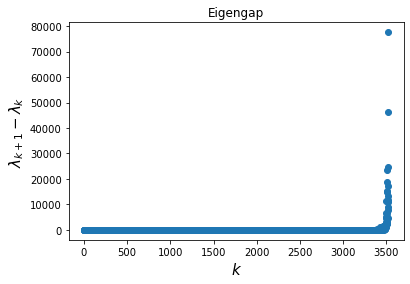

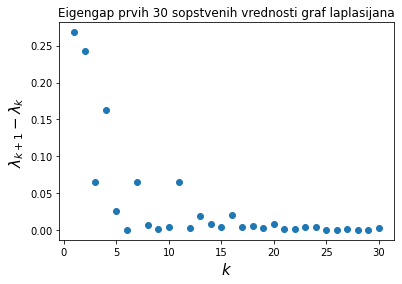

In [41]:
# eigengap


df_gap = df_eig.iloc[:,1].diff()
df_gap = df_gap.astype(np.float64)

df_gap = df_gap[1:]
enumerator_column = np.array(range(1, len(df_gap)+1))

df_gap = pd.DataFrame(list(zip(enumerator_column, df_gap)))
  
plot_scatterplot(df_gap.iloc[:,0], df_gap.iloc[:,1], r'$k$', r'$\lambda_{k+1}-\lambda_k$','Eigengap')

plot_scatterplot(df_gap.iloc[:30,0], df_gap.iloc[:30,1], r'$k$', r'$\lambda_{k+1}-\lambda_k$','Eigengap prvih 30 sopstvenih vrednosti graf laplasijana')

In [42]:
from sklearn.cluster import SpectralClustering
for k in range(2, 30):
    
    clustering = SpectralClustering(n_clusters=k,
    assign_labels="discretize", affinity="precomputed").fit(nx.adjacency_matrix(giant))

    colors = clustering.labels_
    c_string = []
    for c in colors:
        c_string.append(str(c))

    G = nx.Graph()
    for c, label in zip(c_string, giant.nodes()):
        G.add_node(label, color=c)

    for edge in giant.edges(data=True):
        #print(edge)
        G.add_edge(edge[0], edge[1], weight=edge[2]['weight'])

    # nx.write_pajek(G, "etf/spectral3.net")
    
    csizes = np.zeros(k)
    for c in colors:
        csizes[int(c)] += 1
    
    print(f"Podela na {k}: velicine komponenata su {csizes}")

C:\Users\Nikola\AppData\Local\Temp\ipykernel_29496\1897042622.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  assign_labels="discretize", affinity="precomputed").fit(nx.adjacency_matrix(giant))


Podela na 2: velicine komponenata su [3.521e+03 3.000e+00]
Podela na 3: velicine komponenata su [3.516e+03 3.000e+00 5.000e+00]
Podela na 4: velicine komponenata su [3.462e+03 3.000e+00 5.000e+00 5.400e+01]
Podela na 5: velicine komponenata su [3.455e+03 3.000e+00 7.000e+00 5.000e+00 5.400e+01]
Podela na 6: velicine komponenata su [3.448e+03 3.000e+00 7.000e+00 7.000e+00 5.000e+00 5.400e+01]
Podela na 7: velicine komponenata su [3.442e+03 3.000e+00 7.000e+00 7.000e+00 5.000e+00 6.000e+00 5.400e+01]
Podela na 8: velicine komponenata su [3.438e+03 4.000e+00 3.000e+00 7.000e+00 7.000e+00 5.000e+00 6.000e+00
 5.400e+01]
Podela na 9: velicine komponenata su [3.428e+03 4.000e+00 3.000e+00 7.000e+00 7.000e+00 5.000e+00 6.000e+00
 1.000e+01 5.400e+01]
Podela na 10: velicine komponenata su [3.428e+03 4.000e+00 3.000e+00 7.000e+00 3.000e+00 7.000e+00 5.000e+00
 6.000e+00 5.400e+01 7.000e+00]
Podela na 11: velicine komponenata su [3.412e+03 4.000e+00 3.000e+00 6.000e+00 7.000e+00 7.000e+00 5.000e

### 21 - Luvenska metoda

In [ ]:
nx.write_gml(giant, "graphs/snet_giant.gml")

![alt text](images/snet_mod_1-0.png "Bipartitivna mreža i unimodalne projekcije")

Slika: Luvenska metoda. Rezolucija 1.0. Broj komuna 55

![alt text](images/snet_mod_2-0.png "Bipartitivna mreža i unimodalne projekcije")

Slika: Luvenska metoda. Rezolucija 2.0. Broj komuna 15

![alt text](images/snet_mod_0-5.png "Bipartitivna mreža i unimodalne projekcije")

Slika: Luvenska metoda. Rezolucija 0.5. Broj komuna 15

### 22 -  Uocene komune


Uocene su dve vece zajednice (komune):

![alt text](images/snet_komuna_1.png "Bipartitivna mreža i unimodalne projekcije")

Slika: Luvenska metoda. Rezolucija 1.0. Procenat cvorova koji pripadaju komuni je 49.15%

![alt text](images/komuna_snet_2.png "Bipartitivna mreža i unimodalne projekcije")

Slika: Luvenska metoda. Rezolucija 1.0. Procenat cvorova koji pripadaju komuni je 39.11%

### 23 - Mostovi


In [52]:
allBridges = list(nx.bridges(giant))
allBridgesCount = Counter(item for i in allBridges for item in i) 
allBridgesCount.most_common(5)

[('reddit.com', 357),
 ('business', 21),
 ('programming', 15),
 ('Chinese', 13),
 ('technology', 9)]

### 24 - SNet vs SNeT

In [78]:
GT =  nx.read_gml('graphs/snet_t.gml')
exc = [(n, nx.eccentricity(giant, n)) for n in GT]
exc

[('math', 4),
 ('science', 3),
 ('scifi', 3),
 ('reddit.com', 3),
 ('news', 4),
 ('obama', 3),
 ('software', 3),
 ('politics', 3),
 ('gaming', 3),
 ('joel', 3),
 ('gadgets', 3),
 ('worldnews', 3),
 ('entertainment', 3),
 ('linux', 3),
 ('atheism', 3),
 ('philosophy', 3),
 ('photography', 4),
 ('videos', 3),
 ('canada', 4),
 ('ideas', 3),
 ('history', 3),
 ('funny', 3),
 ('bestof', 3),
 ('geek', 3),
 ('offbeat', 3),
 ('netsec', 3),
 ('pics', 3),
 ('programming', 3),
 ('business', 3),
 ('guns', 3),
 ('nsfw', 3),
 ('cogsci', 3),
 ('Health', 3),
 ('technology', 3),
 ('AskReddit', 3),
 ('comics', 3),
 ('Economics', 3),
 ('environment', 3),
 ('WTF', 3)]

Svi cvorovi su rasporedjeni u jezgru SNet

In [89]:
suma =0
for _, i in giant.degree(weight='weight'):
    suma +=i
activity_snet = suma / float(len(giant))
print(activity_snet)

gr = giant.copy()
gr.remove_nodes_from(GT.nodes())

for _, i in gr.degree(weight='weight'):
    suma +=i
activity_snet_t_r = suma / float(len(gr))
print(activity_snet_t_r)

for _, i in GT.degree(weight='weight'):
    suma +=i
activity_snet_t = suma / float(len(GT))

if(activity_snet_t > activity_snet_t_r):
    print("SNetT je aktivnija mreza. Aktivnost iznosi: ", activity_snet_t)
else:
     print("SNet je aktivnija mreza. Aktivnost iznosi: " , activity_snet)


264.9738880918221
529.9477761836442
SNetT je aktivnija mreza. Aktivnost iznosi:  147786.35897435897
